In [1]:
# !pip install --upgrade music21
from music21 import converter, instrument, note, chord, stream, midi
# from google.colab import files
import glob
import os
import gzip
import tarfile    
from torchvision import datasets                  
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split as tts

assert torch.cuda.is_available()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Import Drive for easier saving
from google.colab import drive
drive.mount('/content/drive')

In [2]:
def download_data(filepath):
    if not os.path.exists(os.path.join(filepath, 'mozart_sonatas.tar.gz')):
        datasets.utils.download_url('https://github.com/Foundations-of-Applied-Mathematics/Data/raw/master/RNN/mozart_sonatas.tar.gz', filepath, 'mozart_sonatas.tar.gz', None)

    print('Extracting {}'.format('mozart_sonatas.tar.gz'))
    gzip_path = os.path.join(filepath, 'mozart_sonatas.tar.gz')
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
        out_f.write(zip_f.read())

    print('Untarring {}'.format('mozart_sonatas.tar'))
    tar_path = os.path.join(filepath,'mozart_sonatas.tar')
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))


# Problem 1 #

Download the data.
Write a function that accepts the path to the .mid files, parses the files, and returns a list of the 114208 Notes and Chords as strings. 
There are many element types in MIDI files, so be sure to only look for Notes and Chords.
For the Chords, join the pitches of the Notes in the Chords with a . as in (D3.D2).

Print the length of your list and the number of unique Notes and Chords.


In [10]:
download_data(os.getcwd())

  0%|          | 0/430509 [00:00<?, ?it/s]

Extracting mozart_sonatas.tar.gz
Untarring mozart_sonatas.tar


In [3]:
def order_pitches(pitches):
    return sorted(list(set([str(n) for n in pitches])))

def mid(path):
    """
    Accepts:
    path: file path to mid files
    
    Parses files
    
    Returns:
    notes_chords: list of 114208 notes and chords as strings
    """
    notes_chords = []
    for file in os.listdir(path):
        print(file)
        midi = converter.parse(os.path.join(path,file))
        notes_to_parse = instrument.partitionByInstrument(midi).parts.stream().recurse()
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes_chords += [str(element.pitch)]
            elif isinstance(element, chord.Chord):
                pitches = []
                for i in range(len(element.pitches)):
                    pitches.append(element.pitches[i])

                pitches = order_pitches(pitches)
                notes_chords.append('.'.join(pitches))
            
    return notes_chords
    
    

In [4]:
notes_chords = mid("mozart_sonatas\mozart_sonatas")
print(len(notes_chords))

piano_sonata_279.mid
piano_sonata_280.mid
piano_sonata_281.mid
piano_sonata_282.mid
piano_sonata_283.mid
piano_sonata_284.mid
piano_sonata_309.mid
piano_sonata_310.mid
piano_sonata_311.mid
piano_sonata_330.mid
piano_sonata_331.mid
piano_sonata_332.mid
piano_sonata_333.mid
piano_sonata_400.mid
piano_sonata_457.mid
piano_sonata_545.mid
piano_sonata_547.mid
piano_sonata_570.mid
piano_sonata_576.mid
piano_sonata_593.mid
114208


In [5]:
print(len(set(notes_chords)))

668


# Problem 2 #

Using the list returned in Problem 1, create the training and testing DataLoaders.
Make sure to do all of the following steps:


1) Convert the pitches to integers.

2) Split the data into Long tensors of length 100.

3) Create the labels.

4) Randomly split the data into training, validation, and test sets using an 70/15/15 split.

5) Create the DataLoaders for these sets of data, using batch_size=128 for the training data and batch_size=32 for the validation and test data; also, set shuffle=True for the training data and False for the validation and test data (this is common practice in Deep Learning).
 

Print the length of each DataLoader (they should be 624, 535, and 535, respectively).


In [6]:
pitches_integers = {list(set(notes_chords))[i]:i for i in range(len(set(notes_chords)))}
data = [pitches_integers[pitch] for pitch in notes_chords]

sequence_labels = []
for x in range(len(data)-100):
    sequence_labels.append([torch.LongTensor(data[x:x+100]), data[x+100]])

In [46]:
# lengths=[.7*len(sequence_labels),.15*len(sequence_labels),.15*len(sequence_labels)]
lengths = [79876, 17116, 17116]

train, val, test = random_split(sequence_labels, lengths=lengths)

# Get Loaders
train_loader = DataLoader(train, batch_size=128, shuffle=True, drop_last=True)
valid_loader = DataLoader(val, batch_size=32, shuffle=False)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

624
535
535


# Problem 3 #

Create an LSTM network class.
Have a hidden layer size of 256, and include at least $3$ LSTM layers.
Also have at least $2$ Linear layers.
The last LSTM layer and each of the Linear layers should be followed by a BatchNorm1d layer, for a total of at least $3$ total BatchNorm layers.
The final layer should be a Softmax activation.

Initialize the model.
Define the loss as CrossEntropyLoss, and define the optimizer as RMSprop.

Train the model for at least 30 epochs, saving the weights every epoch. 

After taking a backwards step during training, scale the gradients using 
nn.utils.clip_grad_norm_(model.parameters(), 5)
This will ensure that the gradients are reasonably sized so that the model can learn.

At the end of every epoch, calculate the validation accuracy and mean loss on the validation data.
Remember to change the model to eval() mode when running the validation data and train() when running on the training data.
You will also need to reinitialize the hidden states (h0, h1) since the batch sizes are different.

After the validation accuracy is above 60\%, plot the training and validation losses versus epochs on the same plot.
Also, plot the validation accuracy versus epochs.
Then, print the final test accuracy by running the finished model on the test data.


In [16]:
class RNN(nn.Module):
    """ Recurrent Neural Network Class """

    def __init__(self, n_notes, embedding_dim):
        super(RNN, self).__init__()
    
        self.hidden_size = 128
        self.num_layers = 3
        self.n_notes = n_notes
        self.embedding = nn.Embedding(n_notes, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, self.hidden_size, self.num_layers, batch_first=True)
        self.batch1 = nn.BatchNorm1d(self.hidden_size)
        self.linear1 = nn.Linear(self.hidden_size, 1000)
        self.batch2 = nn.BatchNorm1d(1000)
        self.linear2 = nn.Linear(1000, n_notes)
        self.batch3 = nn.BatchNorm1d(n_notes)
        
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.loss = nn.CrossEntropyLoss()
        
      
    def forward(self, x, hidden):
        embeds = self.embedding(x)
        
        # 3 lstm layers
        lstm_out, hidden = self.lstm(embeds, hidden)
        out = self.batch1(lstm_out[:,-1])
        
        # 2 Linear Layers
        linear_out = self.relu(self.linear1(out))
        out = self.batch2(linear_out)
        linear_out = self.relu(self.linear2(out))
        out = self.batch3(linear_out)
        
        # Final softmax layer
        x = self.softmax(out)
        
        return x, hidden

    def init_hidden(self,batch_size):
        # initialize the hidden layers
        weight = next(self.parameters()).data
        h0 = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device)
        h1 = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device)
        return (h0, h1)

epoch:1, loss:4.6806: 100%|██████████████████████████████████████████████████████████| 624/624 [01:58<00:00,  5.25it/s]


In [30]:
def train(model, train_loader, valid_loader, n_epochs):
    
    optimizer = optim.RMSprop(model.parameters(), lr=.001)
    
    # Set up progress bar
    loop = tqdm(total=len(train_loader), position=0)
    
    mean_train_losses, mean_valid_losses, mean_valid_accs = [], [], []
    for epoch in range(1,n_epochs+1):
        model.train()
        (h0,h1) = model.init_hidden(128)
        
        train_losses = []
        for x_truth, y_truth in train_loader:
            x_truth, y_truth = x_truth.to(device), y_truth.to(device)
            optimizer.zero_grad()
            
            output, (h0,h1) = model(x_truth, (h0,h1))
            h0 = h0.detach()
            h1 = h1.detach()
            
            # Get Training Loss
            loss = model.loss(output, y_truth)
            train_losses.append(loss.item())
            loop.set_description('epoch:{}, loss:{:.4f}'.format(epoch,loss.item()))
            loop.update()
            loss.backward()
            optimizer.step()
            nn.utils.clip_grad_norm_(model.parameters(), 5)

            
            
        torch.save({'epoch': epoch,
                   'model_state_dict': model.state_dict(),
                   'optimizer_state_dict': optimizer.state_dict(),
                   'loss': loss}, 'ckpts/mozart.ckpt')
        
        # Calculate Validation Accuracy
        validation = 0
        valid_losses = []
        model.eval()
        for x_truth, y_truth in valid_loader:
            x_truth, y_truth = x_truth.to(device), y_truth.to(device)
            (h0,h1) = model.init_hidden(len(y_truth))
            y_hat, _ = model(x_truth, (h0,h1))
            loss = model.loss(y_hat, y_truth)
            valid_losses.append(loss.item())
            
            validation += sum(torch.eq(y_truth, y_hat.argmax(1)))/len(y_truth)
            
        mean_valid_acc = validation.item() / len(valid_loader)
        
        mean_train_losses.append(np.mean(train_losses))
        mean_valid_accs.append(mean_valid_acc)
        mean_valid_losses.append(np.mean(valid_losses))
        if mean_valid_acc > .6:
            loop.close()
            break
    loop.close()
    return model, mean_train_losses, mean_valid_losses, mean_valid_accs

In [31]:
model = RNN(668,32)
model.to(device)

model, train_loss, valid_loss, valid_accs = train(model, train_loader, valid_loader, 30)

epoch:30, loss:0.6721: : 18720it [27:10, 11.48it/s]                                                                    


In [34]:
torch.save({'epoch': 30,
                   'model_state_dict': model.state_dict(),
                   'loss': train_loss[-1]}, 'ckpts/mozart.ckpt')

In [35]:
# Calculate Test Accuracy
test_score = 0
model.eval()
for x_truth, y_truth in test_loader:
    x_truth, y_truth = x_truth.to(device), y_truth.to(device)
    (h0,h1) = model.init_hidden(len(y_truth))
    y_hat, _ = model(x_truth, (h0,h1))

    test_score += sum(torch.eq(y_truth, y_hat.argmax(1)))/len(y_truth)

mean_test_acc = test_score.item() / len(test_loader)

0.3944843042676694


In [36]:
print("Test Accuracy: ",mean_test_acc)

Test Accuracy:  0.3944843042676694


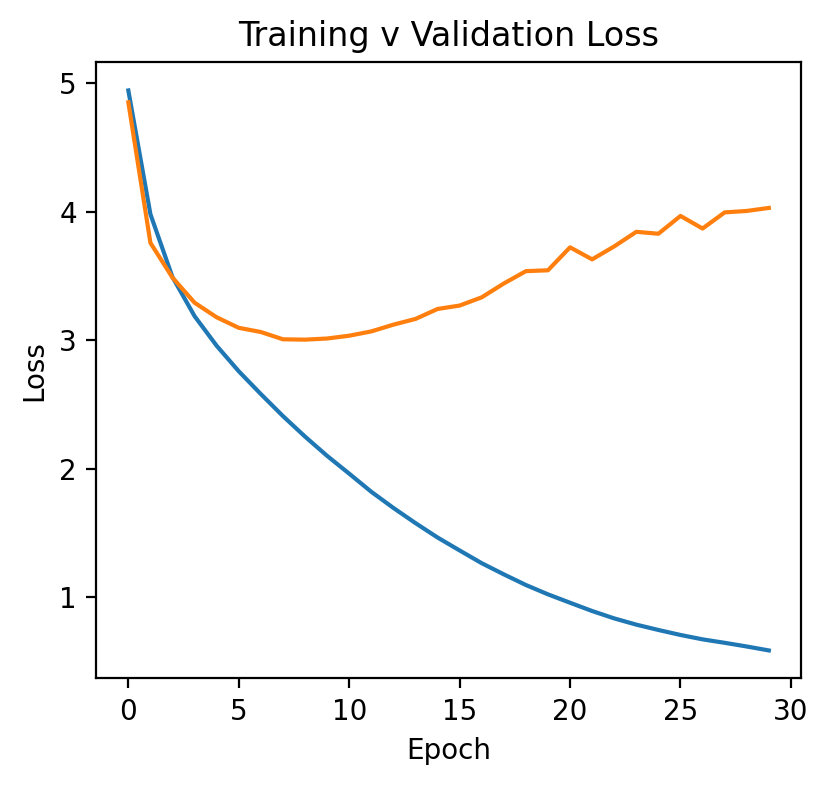

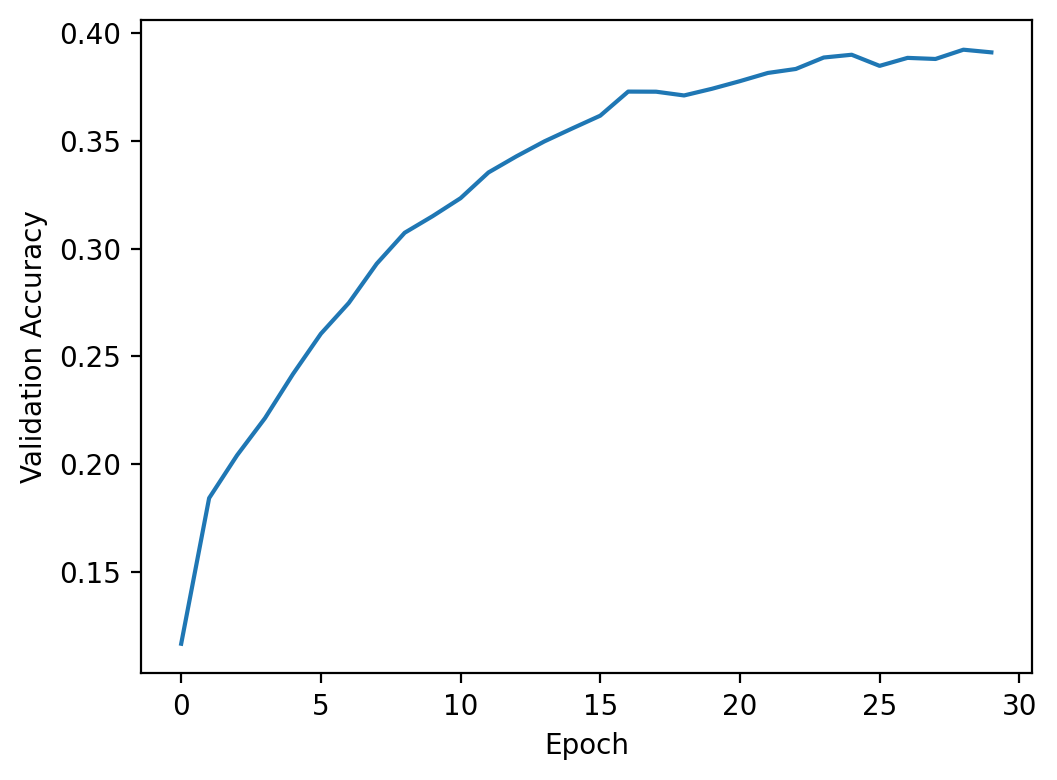

In [32]:
# Plot it
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(train_loss, label="Training Loss")
plt.plot(valid_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training v Validation Loss")

plt.figure(figsize=(10,4))
plt.subplot(122)
plt.plot(valid_accs)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")

plt.tight_layout()
plt.show()

# Problem 4 #

Write a function that randomly chooses a sequence in the test data (which has length 100) and predicts the next $n$ elements, defaulting to 500. 
Combine the initial sequence with the predicted elements, convert them to pitches, and return this list of 600 pitches.

In [37]:
def load_model(filename):
    """ Load a saved model to continue training or evaluate """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # n_notes is the number of unique pitches
    model = Network(n_notes,32)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(),lr=.001)

    checkpoint = torch.load(filename,map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    last_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    model.eval() # Toggle evaluation mode

    return model, criterion, optimizer

In [124]:
def predict(n):
    model.to(device)
    idx = np.random.randint(0,len(test))
    seq, label = test[idx][0], test[idx][1]
    
    seqs = seq.tolist()
    (h0,h1) = model.init_hidden(1)
    for _ in range(n):
        seq = seq.unsqueeze(0).to(device)
        y_hat, _ = model(seq, (h0,h1))
        seqs.append(y_hat.argmax(1).item())
        seq = torch.LongTensor(seqs[-100:])
    
    return seqs

In [125]:
prediction = predict(500)

In [126]:
key_list = list(pitches_integers.keys())
val_list = list(pitches_integers.values())

pitches = [key_list[val_list.index(i)] for i in prediction]
print(pitches)

['E5', 'E4', 'E5', 'B-5', 'G5', 'C#4', 'C#5', 'C#4', 'C#5', 'A5', 'F#5', 'D4', 'D5', 'D4', 'D5', 'D5', 'G#3', 'D6', 'G#4', 'C#5', 'A3', 'C#6', 'A4', 'C5', 'F#3', 'C6', 'F#4', 'B4', 'G3', 'B5', 'G4', 'B4', 'F3', 'B5', 'F4', 'B-4', 'F#3', 'B-5', 'F#4', 'A4', 'E-3', 'A5', 'E-4', 'G#4', 'E3', 'G#5', 'E4', 'G4', 'C#4', 'A3', 'G5', 'G4', 'G5', 'F#4', 'D4', 'B3', 'F#5', 'F#4', 'F#5', 'E4', 'B3', 'G3', 'E5', 'E4', 'E5', 'D4', 'G#3', 'D5', 'D4', 'D5', 'C#4', 'A3', 'C#5', 'D4', 'D5', 'E-4', 'E-5', 'E4', 'E5', 'F4', 'F5', 'F#4', 'F#5', 'G4', 'G5', 'G#4', 'G#5', 'A4', 'A5', 'A3', 'A4', 'A3', 'A4', 'E5', 'C#5', 'G3', 'G4', 'G3', 'G4', 'A4', 'F#3', 'F#4', 'A5', 'F#3', 'A5', 'F#3', 'G5', 'E3', 'F#5', 'A2', 'D6', 'D3', 'F#5', 'F#3', 'A5', 'G2', 'G5', 'F#5', 'A3', 'E5', 'C#5', 'G4', 'D5', 'F#4', 'B4', 'F#5', 'F#4', 'D4', 'G5', 'E5', 'E4', 'G#5', 'B4', 'E4', 'E2.E3', 'A5.G#5', 'B5', 'B4', 'B5', 'B4', 'G4', 'E2.E3', 'G4', 'B4', 'G4', 'G5', 'G4', 'G5', 'G4', 'D3.D4', 'G4', 'B4.D5', 'A4', 'G5', 'F#5', 'G5'

# Problem 5 # 

Convert the predictions from Problem 4 into Music21 Note and Chord objects and save it as 'mozart.mid'.

In [ ]:
notes = []

for offset, pitch in enumerate(pitches):
    new_note = note.Note(pitch)
    # Specify Piano as the instrument type
    new_note.storedInstrument = instrument.Piano()
    notes.append(new_note)
# Create a Chord object using list of Note objects
new_chord = chord.Chord(notes)
# Specify offset for this object
new_chord.offset = offset

midi_stream = stream.Stream(notes)
midi_stream.write('midi', fp='mozart.mid')